In [1]:
%matplotlib inline

import os
import sys
import timeit
import scipy
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ipywidgets import interact
from functools import partial

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from tutorial_utils import *

sns.set_style('darkgrid')

In the first tutorial we established `fit` and `predict` methods for dense/direct/traditional Gaussian processes regression. These methods are relatively fast for small datasets, but scale cubicly in the number of data points, $\mathcal{O}(n^3)$. To see this we've added a helper function which executes some of our fit / predict methods for different sized problems.

We can use this helper to time how long it takes to simply evaluate the covariance matrix between training points and all others:

In [2]:
# Measure the covariance function evaluation
def build_cov(cov_func, X, y, x_test, meas_noise):
    return cov_func(X, X)
sizes, cov_times = zip(*generate_timings(build_cov))

Timing with 1000 measurements: 0.00954963253323166
Timing with 1800 measurements: 0.027272127241500327
Timing with 2600 measurements: 0.059978120056364465
Timing with 3400 measurements: 0.10526312498841435
Timing with 4200 measurements: 0.1671015138272196
Timing with 5000 measurements: 0.24031279161572455


Then we can measure how long the fit method takes:

In [3]:
# Measure the fit step.
def do_fit(cov_func, X, y, x_test, meas_noise):
    return example_fit(cov_func, X, y, meas_noise=meas_noise)
sizes, fit_times = zip(*generate_timings(do_fit))

Timing with 1000 measurements: 0.3816831666820993
Timing with 1800 measurements: 0.6250701666964839
Timing with 2600 measurements: 0.9377159719976286
Timing with 3400 measurements: 1.5849451526689033
Timing with 4200 measurements: 2.04921305567647
Timing with 5000 measurements: 2.3807314864049354


And again, but for the predict step.

In [4]:
# Measure the predict step.
dummy_L = np.tril(np.random.normal(size=(10000, 10000)))
def do_predict(cov_func, X, y, x_test, meas_noise):
    dummy_fit = {
        "train_locations": X,
        "information": y,
        "cholesky": dummy_L[:y.size,:y.size],
        "cov_func": cov_func
    }

    return example_predict(dummy_fit, x_test)

sizes, predict_times = zip(*generate_timings(do_predict))

Timing with 1000 measurements: 0.0017413113043522057
Timing with 1800 measurements: 0.005362872551021012
Timing with 2600 measurements: 0.0107740309147004
Timing with 3400 measurements: 0.01760590205320337
Timing with 4200 measurements: 0.026034471155024875
Timing with 5000 measurements: 0.03424703193595633


Notice that as the number of measurements increases the fit step becomes increasingly complex.

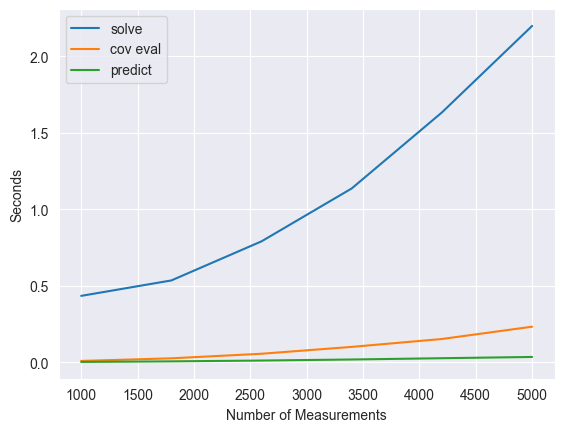

In [5]:
# the fit step requires building the covariance and performing the solve.
solve_times = np.array(fit_times) - cov_times

plt.plot(sizes, solve_times, label="solve")
plt.plot(sizes, cov_times, label="cov eval")
plt.plot(sizes, predict_times, label="predict")
plt.xlabel("Number of Measurements")
plt.ylabel("Seconds")
plt.legend()

The exact timing you'll see obviously depend on your machine, but you should see that the trend is not linear. Extrapolate those fit times out to something like 100,000 measurements and it's going to take a _VERY_ long time to fit a model.

In [6]:
query_sizes = [10000, 50000, 100000]
extrapolated_solve_times = np.polyval(np.polyfit(sizes, solve_times, 3), query_sizes)
pd.Series(extrapolated_solve_times / 60., query_sizes, name="Expected Solve Time (minutes)").to_frame()

,Expected Solve Time (minutes)
10000,0.118816
50000,-4.010234
100000,-53.114372


Yikes, my machine says one hour to train with 100k measurements. Thankfully there are a lot of techniques which focus on mitigating the $\mathcal{O}(n^3)$ bottleneck. For a great review see [When Gaussian Process Meets Big Data: A Review of Scalable GPs](https://arxiv.org/abs/1807.01065). Here we describe the Fully Independent Training Conditional approach (FITC).

These Sparse methods (FITC and its relatives) rely heavily on the Nystrom approximation which can be used to decribe some large dense symmetric matrix $A \in \mathbb{R}^{n, n}$ as a composition of low rank matrices,
$$
\begin{align}
A &= B C^{-1} B^T \\
&= \begin{bmatrix}
B_0 \\
\vdots \\
B_N
\end{bmatrix}
\begin{bmatrix}
C^{-1}
\end{bmatrix}
\begin{bmatrix}
B_0 &
\cdots &
B_N
\end{bmatrix}
\end{align}
$$
where $B \in \mathbb{R}^{n, m}$ is a tall skinny matrix of rank $m$ and $C \in \mathbb{R}^{m, m}$ is a smaller symmetric matrix. To help build some intuition around the equation, let's consider the case where we think our data is described by a very simple model.

Remember that we wrote the measurements, $\mathbf{y}$, in terms of the unknown function, $f(x)$ and noise, $\mathbf{\epsilon} \sim \mathcal{N}\left(0, \sigma_{\epsilon}^2\right)$,
$$
\mathbf{y} = f(x) + \mathbf{\epsilon}
$$
Let's say that we think $f(x) = a$. In otherwords, we think the unknown function is a constant which doesn't even depend on $x$. We don't know the value of $a$ though and would like to estimate it. We can place a prior on its magnitude: $\mathbf{a} \sim \mathcal{N}(0, \sigma_a^2)$. The covariance function for a constant function is relatively simple, no matter which arguments you provide the covariance is always the same,
$$
c(x, x') = \sigma_a^2
$$
We can then use the covariance fuction to build the prior,
$$
\begin{align}
\mathbf{y} & \sim \mathcal{N}\left(0, \Sigma_{ff} + \sigma_{\epsilon}^2 I\right) \\
& \sim \mathcal{N}\left(0,
\begin{bmatrix}
  \sigma_a^2 & \ldots & \sigma_a^2 \\
  \vdots & \ddots & \vdots \\
  \sigma_a^2 & \ldots & \sigma_a^2
\end{bmatrix} + \sigma_{epsilon}^2 I\right)
\end{align}
$$
In this case $\Sigma_{ff}$ has the same value everywhere, it's $n$ by $n$ but is only rank 1, so it isn't invertible.  We _could_ directly plug $\Sigma_{ff} + \sigma_{\epsilon}^2 I$ into the equation for the posterior,
$$
\mbox{E}\left[\mathbf{f}^*|y\right] =\Sigma_{*f} \left(\mathbb{1} \sigma_a^{2} \mathbb{1}^T + \sigma_{\epsilon}^2 I\right)^{-1} y
$$
Here's an example of what such a prediction would look like:

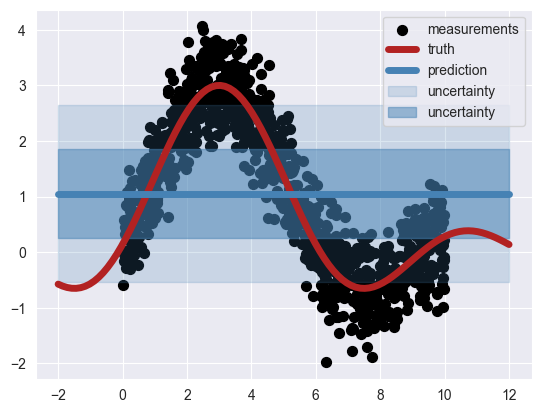

In [4]:
X, y = generate_training_data(1000)
SIGMA_CONSTANT = 100.
MEAS_NOISE_CONSTANT = 20.

def constant_covariance(x_i, x_j, sigma_constant=SIGMA_CONSTANT):
    m = np.atleast_1d(x_i).shape[0]
    n = np.atleast_1d(x_j).shape[0]
    return sigma_constant * sigma_constant * np.ones((m, n))

x_gridded = np.linspace(LOWEST, HIGHEST, 101)
mean_pred, cov_pred = example_fit_and_predict(constant_covariance, X, y,
                                              x_gridded, meas_noise=MEAS_NOISE_CONSTANT)

plot_measurements(X, y)
plot_truth(x_gridded)
plot_spread(x_gridded, mean_pred, np.sqrt(np.diag(cov_pred)))
plt.legend()

Clearly a constant is not a good fit (but that's not the point), let's see how long it took to fit and predict,

In [5]:
x_star = np.array([0.])
%timeit example_fit_and_predict(constant_covariance, X, y, x_star, meas_noise=MEAS_NOISE)

1.46 s ± 68.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Compare that with the squared exponential,

In [8]:
%timeit example_fit_and_predict(example_squared_exponential, X, y, x_star, meas_noise=MEAS_NOISE)

1.13 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


You should see slight timing differences, probably the constant function is faster (because the covariance function is faster to evaluate) but you should see the same order of magnitude because in both approaches the prior covariance matrix that we need to invert, $\left(\mathbb{1} \sigma_a^{2} \mathbb{1}^T + \sigma_{\epsilon}^2 I\right)$, is an $n$ by $n$ matrix. Considering how much simpler the constant function is we'd hope it would be very easy to estimate.

Thankfully, we can use the [matrix inversion lemma](https://en.wikipedia.org/wiki/Woodbury_matrix_identity) which states that for invertible matrices $A$ and $C$,
$$
\left(A + U C U^T\right)^{-1} = A^{-1} - A^{-1} U \left(C^{-1} + U^T A^{-1} U\right)^{-1} U^T A^{-1}
$$
At first this may not appear to help, but if $A$ is easy to invert (diagonal matrix for example) then using the lemma can lead to much faster solves. In this case, by setting $A = \sigma_{\epsilon}^2 I$ with $U = \mathbb{1}$ and $C = \sigma_a^{2}$, we can arrive at an extremely efficient solver,
$$
\begin{align}
\left(\sigma_{\epsilon}^2 I + \mathbb{1} \sigma_a^{2} \mathbb{1}^T\right)^{-1} &=
\sigma_{\epsilon}^{-2} I - \sigma_{\epsilon}^{-2} I \mathbb{1} \left(\sigma_a^{-2} + \mathbb{1}^T \sigma_{\epsilon}^{-2} I \mathbb{1}\right)^{-1} \mathbb{1}^T \sigma_{\epsilon}^{-2} I \\
&= \sigma_{\epsilon}^{-2} I - \sigma_{\epsilon}^{-2} \mathbb{1} \left(\sigma_a^{-2} + n \sigma_{\epsilon}^{-2}\right)^{-1} \mathbb{1}^T \sigma_{\epsilon}^{-2} \\
&= \sigma_{\epsilon}^{-2} \left(I - \frac{\sigma_{\epsilon}^{-2}}{\sigma_a^{-2} + n \sigma_{\epsilon}^{-2}} \mathbb{1} \mathbb{1}^T \right)
\end{align}
$$
Notice that in this example $C$ is a one by one matrix, so we could do all the matrix inversions analytically. Let's actually implement a fit/predict for this for the special case. We can break the steps down into, first compute $\gamma$,
$$
\gamma = \frac{\sigma_{\epsilon}^{-2}}{\sigma_a^{-2} + n \sigma_{\epsilon}^{-2}} 
$$
Then use that to get
$$
\left(\Sigma_{ff} + \sigma_{\epsilon}^2 I\right)^{-1} y = \sigma_{\epsilon}^{-2} \left(I - \gamma \mathbb{1} \mathbb{1}^T \right)y
$$
Notice that $\mathbb{1}^T y = \sum y_i = \mbox{sum}[y]$, so,
$$
\sigma_{\epsilon}^{-2} \left(I - \gamma \mathbb{1} \mathbb{1}^T \right)y = \sigma_{\epsilon}^{-2}\left( y - \gamma \mbox{sum}[y]\right)
$$
and finally we multiply through by $\Sigma_{*f} = \sigma_a^2 \mathbb{1}^T$ which involves another sum,
$$
\frac{\sigma_a^2}{\sigma_{\epsilon}^{2}} \mbox{sum}\left[y - \gamma \mbox{sum}[y]\right]
$$

In [ ]:
def direct_fit_predict_constant(X, y, sigma_constant, meas_noise):
    # YOUR CODE HERE
    # gamma = sigma_e^{-2} / (sigma_a^{-1} + n sigma_e^{-2})
    # gamma = 
    # ratio = sigma_a^2 / sigma_e^2
    # ratio = 
    # mean_prediction = 
    return mean_prediction # (scalar)

# example call for debugging
#X_small, y_small = generate_training_data(3)
#example_direct_fit_predict_constant(X_small, y_small, SIGMA_CONSTANT, MEAS_NOISE)

TEST_DIRECT_FIT_PREDICT(direct_fit_predict_constant)

In [ ]:
%timeit direct_fit_predict_constant(X, y, SIGMA_CONSTANT, MEAS_NOISE)

In [ ]:
dense_mean, _ = example_fit_and_predict(constant_covariance, X, y, x_star, meas_noise=MEAS_NOISE)
direct_mean = direct_fit_predict_constant(X, y, SIGMA_CONSTANT, MEAS_NOISE)
print(f"Dense Mean:  {dense_mean[0]}\nSparse Mean: {direct_mean}")

Same result, but something like 1000x faster!

But of course, the assumption that the function was constant was awful. To generalize this and use vocabulary more common in litterature, we'd call $u = [a]$ our inducing points. The inducing points are the basis for a low rank approximation, the name is descriptive, inducing points are like filter state which transfer (or induce) information from measurements to predictions. It's common to use $Q$ to represent the covariance captured by the inducing points,
$$
\begin{align}
Q_{ij} &\approx \Sigma_{iu} \Sigma_{uu}^{-1} \Sigma_{uj}
\end{align}
$$
And we can then write our approximate prior on $\mathbf{y}$ as,
$$
\begin{align}
\Sigma_{yy} &\approx \Sigma_{fu} \Sigma_{uu}^{-1} \Sigma_{uf} + D \\
& = Q_{ff} + D
\end{align}
$$
Here we've added $D$ which is a diagonal matrix capturing any of the covariance that was not captured using the inducing points,
$$
\begin{align}
D &= \mbox{diag}\left(\Sigma_{yy} - Q_{ff}\right) \\
  &= \begin{bmatrix}
  \Sigma_{00} - Q_{00} + \sigma_{\epsilon}^2 & 0 & 0 \\
  0 & \ddots & 0 \\
  0 & 0 & \Sigma_{nn} - Q_{nn} + \sigma_{\epsilon}^2 \\
  \end{bmatrix}
\end{align}
$$
If we plug this into the posterior mean equation we get,
$$
\mbox{E}\left[\mathbf{f}^*|y\right] = \Sigma_{*f}\left(\Sigma_{fu} \Sigma_{uu}^{-1} \Sigma_{uf} + D\right)^{-1} y
$$
Which we've already determined is not actually computationally helpful. Using the Nystrom approximation again and using $Q_{*f}$ instead of $\Sigma_{*f}$ gives us,
$$
\begin{align}
\mbox{E}\left[\mathbf{f}^*|y\right] &\approx Q_{*f}\left(\Sigma_{fu} \Sigma_{uu}^{-1} \Sigma_{uf} + D\right)^{-1} y \\
&= \Sigma_{*u}\Sigma_{uu}^{-1}\Sigma_{uf}\left(\Sigma_{fu} \Sigma_{uu}^{-1} \Sigma_{uf} + D\right)^{-1} y \\
&= \Sigma_{*u}\left(\Sigma_{uu} + \Sigma_{uf} D^{-1} \Sigma_{fu}\right)^{-1} \Sigma_{uf} D^{-1} y
\end{align}
$$
That last step is probably not obvious, but it's a variation on the matrix inversion lemma (See [The Matrix Cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) for details). Below we'll write a function which produces mean predictions using this sparse approximation. The predictive covariance can be derived using a similar approach,
$$
\begin{align}
\mbox{COV}\left[\mathbf{f}^*|y\right] &= K_{**} - K_{*u} K_{uu}^{-1} K_{u*} + K_{*u} \left(\Sigma_{uu} + \Sigma_{uf} D^{-1} \Sigma_{fu}\right)^{-1} K_{u*}
\end{align}
$$
Now let's actually implement a sparse solver. To summarize we'll need to:
- Construct the covariance matrices $K_{uu}$, $K_{uf}$, $K_{*u}$, and $K_{ss}$ using the covariance function.
- Compute $D = \mbox{diag}[K_{ff} - Q_{ff} + \sigma_{\epsilon}^2]$ which will require building $Q_{ff} = K_{fu} K_{uu}^{-1} K_{uf}$ (or better yet, just finding the diagonal of the result)
- Compute $S = K_{uu} + K_{uf} D^{-1} K_{fu}$
- Compute $\mu = K_{*u} S^{-1} K_{uf} D^{-1} y$
- Compute $V = K_{**} - K_{**} - K_{*u} K_{uu}^{-1} K_{u*} + K_{*u} S^{-1} K_{u*}$
There are a lot of different ways to go about this, and plenty of room for optimization ... but probably best to ignore such optimizations for this example.
- Return $\mathbf{f^*}|y \sim \mathcal{N}(\mu, V)$

In [ ]:
# A helper to solve D^-1 b when D is a vector representing diagonal elements
def diagonal_solve(D, b):
    b = np.array(b)
    if b.ndim == 1:
        return b / D
    else:
        return b / D[:, None]

# A helper to evaluate a covariance function to obtain only the
# diagonal elements of a covariance matrix.
#
# diagonal_covariance(cov_func, X) == np.diag(cov_func(X, X))
def diagonal_variance(cov_func, X):
    return np.array([cov_func(X[i], X[i])[0, 0]
                     for i in range(X.shape[0])])


def sparse_fit_and_predict(cov_func, X, y, u, x_star, meas_noise):
    # K_uu = 
    # K_uf = 
    # K_ff_diag = 
    # K_su = 
    # K_ss = 

    # Find the diagonal of Q_ff = K_fu K_uu^-1 K_uf
    # Q_ff_diag = 
    # D = 
    # S = 
    
    # mean = 
    # cov = 
    return mean, cov

u = np.array([0.])

# example call to fit and predict:
# sparse_fit_and_predict(constant_covariance, X, y, u, x_star, MEAS_NOISE)

TEST_SPARSE_FIT_AND_PREDICT(sparse_fit_and_predict)

In [ ]:
%timeit sparse_fit_and_predict(constant_covariance, X, y, u, x_star, MEAS_NOISE)

Out generalized solver may not be quite as fast as using the extremely optimized version we did above (which took advantage of known structure to compute inversions analyticaly) but it should still be an order of magnitude faster than the dense solver.

The next question is how to choose the inducing points, $u$. In the constant examples, we just set $u$ to be the constant offset. But it's much more common to pick points spanning the domain. How many points are used and where exactly they get placed is very problem dependent. Here's an interactive plot, be sure to change the number of inducing points to see how that changes the prediction,

In [ ]:
example_cov_func = partial(example_squared_exponential, ell=3., sigma=2.)

def plot_fit_and_predict(n_measurements, n_inducing_points):
    xs = X[:int(n_measurements)]
    ys = y[:int(n_measurements)]
    U = np.linspace(LOW, HIGH, n_inducing_points)
    fit_model = example_sparse_fit(example_cov_func, xs, ys, U, meas_noise=0.35)
    pred_mean, pred_cov = example_sparse_predict(fit_model, x_gridded)
    plot_spread(x_gridded, pred_mean, np.diag(pred_cov))
    plot_truth(x_gridded)
    plot_measurements(xs, ys)

    inducing_mean, _ = example_sparse_predict(fit_model, U)
    plt.scatter(U, inducing_mean, s=200,
                edgecolor="white", color="forestgreen",
                zorder=100, label="inducing points")
    plt.ylim([-1, 5])
    plt.legend()

@interact
def interactive_plot_fit_and_predict(n_measurements=(10, 1000., 10),
                                     n_inducing_points=(1, 15, 1)):
    plot_fit_and_predict(n_measurements, n_inducing_points)

# How Many Inducing Points Are Needed?

One way to get a sense for how many inducing points are needed for a given problem is to actually build the approximate prior and compare it to the actual prior. Here are some images showing the actual prior for gridded X, along side the approximate prior and then the difference between the two when we use five inducing points,

In [ ]:
def nystrom_approximation(cov_func, n):
    u = np.linspace(np.min(x_gridded), np.max(x_gridded), n)
    K_uu = cov_func(u, u)
    K_uf = cov_func(u, x_gridded)
    Q_ff = K_uf.T @ np.linalg.solve(K_uu, K_uf)
    return Q_ff


def plot_nystrom_approximation(n):
    K_ff = example_cov_func(x_gridded, x_gridded)
    Q_ff = nystrom_approximation(example_cov_func, n)
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    axes[0].imshow(K_ff)
    axes[0].set_title("Actual Prior")

    axes[1].imshow(Q_ff)
    axes[1].set_title("Approximate Prior")

    axes[2].imshow(K_ff - Q_ff, cmap="coolwarm",
                   norm=plt.Normalize(vmin=-0.5, vmax=0.5))
    _ = axes[2].set_title("Error")

plot_nystrom_approximation(4)

It's very obvious the approximate prior varies significantly from the actual prior. But as we increase the number of inducing points that changes,

In [ ]:
plot_nystrom_approximation(5)

In [ ]:
plot_nystrom_approximation(7)

It appears that with 7 inducing points our approximate priori is very nearly matching the actual prior. This sort of analysis can be a very helpful tool for deciding if you've designed a model which _should_ provide a good approximation to the full problem.

Just to triple check we can compare the sparse GP prediction to the dense GP,

In [ ]:
u = np.linspace(LOW, HIGH, 7)
sparse_mean, sparse_cov = example_sparse_fit_and_predict(example_cov_func, X, y, u, x_gridded, meas_noise=0.35)
dense_mean, dense_cov = example_fit_and_predict(example_cov_func, X, y, x_gridded, meas_noise=0.35)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plot_measurements(X, y)
truth = plot_truth(x_gridded)
sparse = plot_spread(x_gridded, sparse_mean, np.diag(sparse_cov), ax=ax, color="forestgreen")
dense = plot_spread(x_gridded, dense_mean, np.diag(dense_cov), ax=ax, color="steelblue")
ax.legend(handles=[truth, sparse, dense], labels=["truth", "sparse", "dense"])

The sparse fit is indistiguishable from the truth inside the range spanned by the measurements. Outside that range we didn't place any inducing points, so the predictions differ a bit, but overall this is probably a satsifactory approximation.

# How Much Faster 

Next question, does using this approximation help speed up the training process?

In [ ]:
# Measure the predict step.
def do_sparse_fit_predict(cov_func, X, y, x_test, meas_noise):
    u = np.linspace(LOW, HIGH, 7)
    return example_sparse_fit_and_predict(cov_func, X, y, u, x_test, meas_noise)

sizes, sparse_times = zip(*generate_timings(do_sparse_fit_predict))

In [ ]:
# Measure the predict step.
def do_dense_fit_predict(cov_func, X, y, x_test, meas_noise):
    return example_fit_and_predict(cov_func, X, y, x_test, meas_noise)

sizes, dense_times = zip(*generate_timings(do_dense_fit_predict))

In [ ]:
plt.plot(sizes, dense_times, label="dense")
plt.plot(sizes, sparse_times, label="sparse")
plt.xlabel("Number of Measurements")
plt.ylabel("Seconds")
plt.legend()

For this particular example a small number of inducing points seems to nearly perfectly capture the prior and the result is a MASSIVE speedup. In practice the number of inducing points required (and what exactly they represent) is problem specific, but if you find yourself in a situation where training a GP and the model fitting is taking too long, a sparse approximation like FITC/PITC/VFE could be a good option.

A few notes:
- In this example we simply prescribed evenly spaced inducing points. A lot of the litterature includes the inducing points as hyper parameters and will solve for the parameters (like length scale etc) AND the locations of the inducing points which collectively maximize the likelihood (or other objective)
- One nice thing about these sparse approximation approaches is that you don't neccesarily need to change the model. If you're fitting a dense GP using a squared exponential covariance, you can switch to a sparse GP and retain the same model. Provided you've properly selected inducing points the result _should_ be identical but just better prepared for scaling.

Remember at the beginning we guessed it would take an hour to fit with 100k data points? Let's try it with the sparse GP,

In [ ]:
X_large, y_large = generate_training_data(100000)
plot_measurements(X_large, y_large)
plot_truth(x_gridded)
sparse_mean, sparse_cov = example_sparse_fit_and_predict(example_cov_func, X, y, u, x_gridded, meas_noise=0.35)
plot_spread(x_gridded, sparse_mean, np.diag(sparse_cov))
plt.legend()

It probably took longer to generate the plot than it did to fit the model.